In [1]:
import orbipy as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import math

In [2]:
def get_polar_coordinates(state, center):
    x, y, z = state[0] - center, state[1], state[2]
    r = x ** 2 + y ** 2 + z ** 2
    
    theta = math.atan2((y ** 2 + z ** 2) ** 0.5, -x) # for 3 dimensions btw, this does not keep the sign of y.
    # Also we flip the x coordinate ("-x"), because eventSPL by default thinks data is for L2 point, and it flips the x coordinate if the point is L1 (which it is - unless specified, as well. weird, yes)
    
    return theta, r

def generate_pr_data_for_orbit(data):
    polar_coordinates = np.array([get_polar_coordinates(state, model.L1) for state in data])
    thetas = polar_coordinates[:,0]
    rs = polar_coordinates[:,1]
    
    interpolation = interpolate.interp1d(thetas, rs, kind='cubic', fill_value='extrapolate')
    thetas_720 = np.linspace(0, np.pi, 720)
    rs_new = interpolation(thetas_720)
    return rs_new

In [3]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
halo_orbits = pd.read_csv('/home/tka4nik/Downloads/HLY_L1_Earth-Moon (default).csv', sep=' ')

pr_dataset = []
for _, orbit in halo_orbits.iterrows():
    print(_, end=' ')
    zero_state = model.get_zero_state().copy()
    zero_state[0] = orbit['x']
    zero_state[2] = orbit['z']
    zero_state[4] = orbit['vy']
    
    event = [op.eventY(count=3)]
    det = op.event_detector(model, event)
    df, ev = det.prop(zero_state, 0.0, np.pi*3, last_state='last')
    
    df_half = df[(df['t'] >= ev.iloc[0]['t']) & (df['t'] <= ev.iloc[1]['t'])]
    df_numpy = df_half[['x','y','z']].to_numpy()
    pr = generate_pr_data_for_orbit(df_numpy)
    pr_dataset.append(pr)
    
pr_dataset_numpy = np.array(pr_dataset)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [4]:
np.save('data/datasets/PR_HLY_L1_Earth-Moon (default)', pr_dataset_numpy)
print(pr_dataset_numpy[0])

[1.00914953e-08 1.00917005e-08 1.00922551e-08 1.00931599e-08
 1.00944159e-08 1.00960238e-08 1.00979845e-08 1.01002988e-08
 1.01029676e-08 1.01059918e-08 1.01093721e-08 1.01131094e-08
 1.01172046e-08 1.01216585e-08 1.01264720e-08 1.01316459e-08
 1.01371811e-08 1.01430783e-08 1.01493385e-08 1.01559625e-08
 1.01629511e-08 1.01703053e-08 1.01780257e-08 1.01861133e-08
 1.01945690e-08 1.02033935e-08 1.02125880e-08 1.02221538e-08
 1.02320926e-08 1.02424058e-08 1.02530950e-08 1.02641616e-08
 1.02756073e-08 1.02874334e-08 1.02996417e-08 1.03122334e-08
 1.03252104e-08 1.03385744e-08 1.03523277e-08 1.03664722e-08
 1.03810100e-08 1.03959432e-08 1.04112738e-08 1.04270038e-08
 1.04431354e-08 1.04596705e-08 1.04766114e-08 1.04939605e-08
 1.05117206e-08 1.05298943e-08 1.05484843e-08 1.05674934e-08
 1.05869241e-08 1.06067792e-08 1.06270615e-08 1.06477735e-08
 1.06689181e-08 1.06904984e-08 1.07125180e-08 1.07349801e-08
 1.07578882e-08 1.07812456e-08 1.08050557e-08 1.08293219e-08
 1.08540475e-08 1.087923

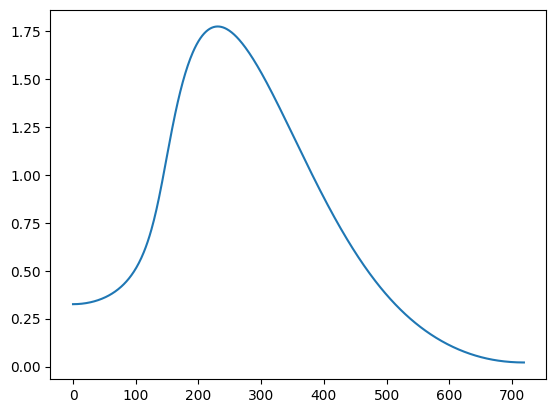

In [5]:
plt.plot(pr_dataset_numpy[-1])

In [6]:
def get_xy_from_polar_coordinates(theta, r):
    x = (r**0.5) * np.cos(theta)
    x = -x # Flip back from the already flipped position, because its an L1 point
    x += model.L1
    y = (r**0.5) * np.sin(theta) # Why r**0.5??? But it works
    return np.column_stack((x, y))

def calculate_velocity_from_jacobi_constant(xy, J):
    return 2*model.omega(np.array([xy[0], xy[1], 0.0])) - J

def mask(velocity):
    return np.where(velocity <= 0)[0].size

def find_jc_threshold_multiplier(J_HLY, xy_coordinates, lower=1.0, upper=2.0, tol=1e-20, max_iter=100):
    for _ in range(max_iter):
        jc_multiplier = (lower + upper) / 2.0
        J0 = J_HLY * jc_multiplier
        velocity_array = np.array([calculate_velocity_from_jacobi_constant(xyi, J0) for xyi in xy_coordinates])

        count = mask(velocity_array)
        
        if count > 0:
            # Current multiplier is "sufficient", try to lower it further.
            upper = jc_multiplier
        else:
            # Not enough elements, need to increase the multiplier.
            lower = jc_multiplier
        
        if (upper - lower) < tol:
            print("tol")
            break
        if 3 >= count > 0:
            print("low enough")
            break
    return jc_multiplier, velocity_array

In [7]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
halo_orbits = pd.read_csv('/home/tka4nik/Downloads/HLY_L1_Earth-Moon (default).csv', sep=' ')
rs = np.load('../data/datasets/PR_HLY_L1_Earth-Moon (default).npy')

J_HLYs = np.array([model.jacobi(state.to_numpy()) for _, state in halo_orbits.iterrows()])

sp_dataset = []

for i in range(len(halo_orbits)):
    thetas = np.linspace(0., np.pi, 720) # 720 - magic number from eventSPL
    xy_coordinates = get_xy_from_polar_coordinates(thetas, rs[i])
    J_HLY = J_HLYs[i]
    
    multiplier, velocity = find_jc_threshold_multiplier(J_HLY, xy_coordinates)
    
    split_point = thetas[int(np.where(velocity <= 0)[0].mean())]
    print(f'{i}: {split_point}, {np.where(velocity <= 0)[0]}')
    sp_dataset.append(np.array([J_HLY, J_HLY*multiplier, split_point]))
    
sp_dataset_numpy = np.array(sp_dataset)

low enough
0: 1.5686116309300913, [359 360]
low enough
1: 1.5729810226597016, [359 360 361]
low enough
2: 1.5729810226597016, [359 360 361]
low enough
3: 1.5729810226597016, [360 361]
low enough
4: 1.5729810226597016, [360 361]
low enough
5: 1.5729810226597016, [360 361]
low enough
6: 1.5729810226597016, [360 361]
low enough
7: 1.5729810226597016, [360 361]
low enough
8: 1.5729810226597016, [360 361]
low enough
9: 1.5773504143893118, [360 361 362]
low enough
10: 1.5773504143893118, [360 361 362]
low enough
11: 1.5773504143893118, [360 361 362]
low enough
12: 1.5773504143893118, [360 361 362]
low enough
13: 1.5773504143893118, [361]
low enough
14: 1.5773504143893118, [361]
low enough
15: 1.5773504143893118, [361]
low enough
16: 1.5773504143893118, [361]
low enough
17: 1.5773504143893118, [361]
low enough
18: 1.5773504143893118, [360 361 362]
low enough
19: 1.5773504143893118, [361 362]
low enough
20: 1.5773504143893118, [360 361 362]
low enough
21: 1.5773504143893118, [361 362]
low enou

In [9]:
np.savetxt("../data/datasets/SP_HLY_L1_Earth-Moon (default).csv", sp_dataset_numpy)

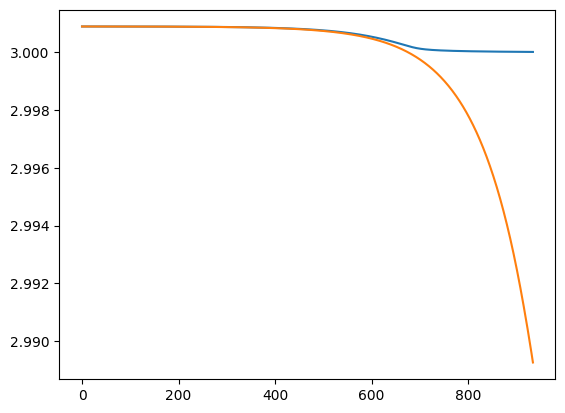

In [12]:
tmp = np.loadtxt('/home/tka4nik/Downloads/SP_HLY_L1_Sun-Earth (default).csv')
plt.plot(tmp[:,1])
plt.plot(tmp[:,0])

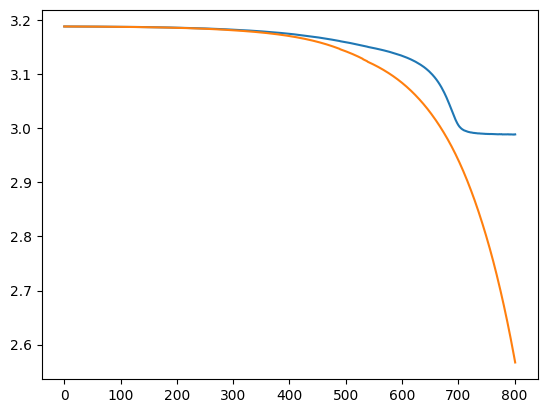

In [13]:
tmp = np.loadtxt('../data/datasets/tmp/SP_HLY_L1_Earth-Moon (default).csv')
plt.plot(tmp[:,1])
plt.plot(tmp[:,0])